# Reading the Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, fsolve

In [6]:
results = {}

In [64]:
RANDOM_SEED = 666
SAMPLE_SIZE = 5000
SAMPLE_PATH = '../data/full_sample.csv'

In [65]:
ord_sample = pd.read_csv(SAMPLE_PATH)

if not SAMPLE_SIZE == ord_sample.shape[0]:
    ord_sample = ord_sample.sample(SAMPLE_SIZE, random_state=RANDOM_SEED)

In [66]:
ord_sample.head()

,order_number,within_promised_time
0,27877,1
1,5620,0
2,72807,0
3,14269,1
4,84171,1


# Definition of the prior

In [68]:
from scipy import stats

def build_beta_prior_expert_knowledge(mean, lower_lim, upper_lim, alpha, lower_search_lim=0, upper_search_lim=20):

    for b in range(lower_search_lim, upper_search_lim):
        a = b * mean/(1-mean)
        if stats.beta.cdf(lower_lim,a, b) < alpha and stats.beta.cdf(upper_lim, a, b) > 1-alpha:
            break

    return round(a), round(b)

a_prior, b_prior = build_beta_prior_expert_knowledge(
    mean=0.75,
    lower_lim=0.7,
    upper_lim=0.9,
    alpha=0.01
)

prior_dist = stats.beta(a_prior, b_prior)

$$ \frac{a}{a + b} = E[\theta|X]$$

$$ a = \frac{bE[\theta|X]}{1-E[\theta|X]} $$

# Calculating Posterior Distribution

In [70]:
sum_X = ord_sample['within_promised_time'].sum()
n = SAMPLE_SIZE

In [71]:
a_post = a_prior + sum_X
b_post = b_prior + n - sum_X

In [72]:
posterior_dist = stats.beta(a_post, b_post)

# Finding tangent Region


$$ 
T_x = \{\theta \in \Theta:f(\theta|x) \ge \displaystyle \sup_{\theta \in \Theta_0}f(\theta|x)\}
$$

In [73]:
t_0 = 0.90
f_t0 = posterior_dist.pdf(t_0)

In [74]:
def build_tangent_region(params, f_t0):
    l1 = params
    return (posterior_dist.pdf(l1) - f_t0)

In [75]:
init_guess_tg = [posterior_dist.ppf(1e-3)]

In [76]:
res_tang_region = fsolve(
    build_tangent_region,
    init_guess_tg,
    args=(f_t0,)
)

In [78]:
tg_region = (min(res_tang_region[0], t_0), max(res_tang_region[0], t_0))

# Calculating e-value

$$
E_v(\Theta_0|X) = 1 - P(tg_{lower} \le \theta \le tg_{upper})
$$

In [80]:
def calculate_e_value(posterior, tg_lower, tg_upper):
    return 1 - (posterior.cdf(tg_upper) - posterior.cdf(tg_lower))

In [81]:
ev = calculate_e_value(posterior_dist, tg_region[0], tg_region[1])

# Consolidating Results

In [83]:
results[SAMPLE_SIZE] = {
    'sample_dist': ord_sample['within_promised_time'].value_counts(1).sort_values(),
    'posterior': posterior_dist,
    'tg_region': tg_region,
    'e_value': ev
}

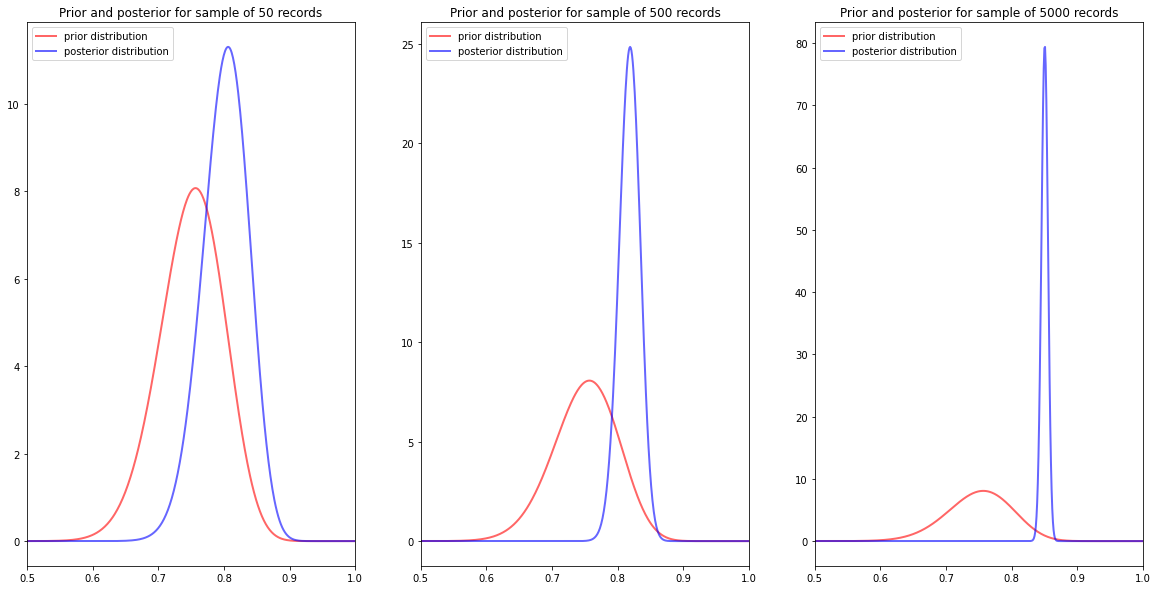

In [84]:
x = np.linspace(0, 1, 1000)
fig, ax = plt.subplots(1, 3, figsize=(20,10))

for i, key in enumerate(results):
    ax[i].plot(x, prior_dist.pdf(x),
              'r-', lw=2, alpha=0.6, label='prior distribution')
    ax[i].plot(x, results[key]['posterior'].pdf(x),
             'b-', lw=2, alpha=0.6, label='posterior distribution')
    ax[i].legend()
    ax[i].set_title(f'Prior and posterior for sample of {key} records')
    ax[i].set_xlim(0.5, 1)
plt.show()

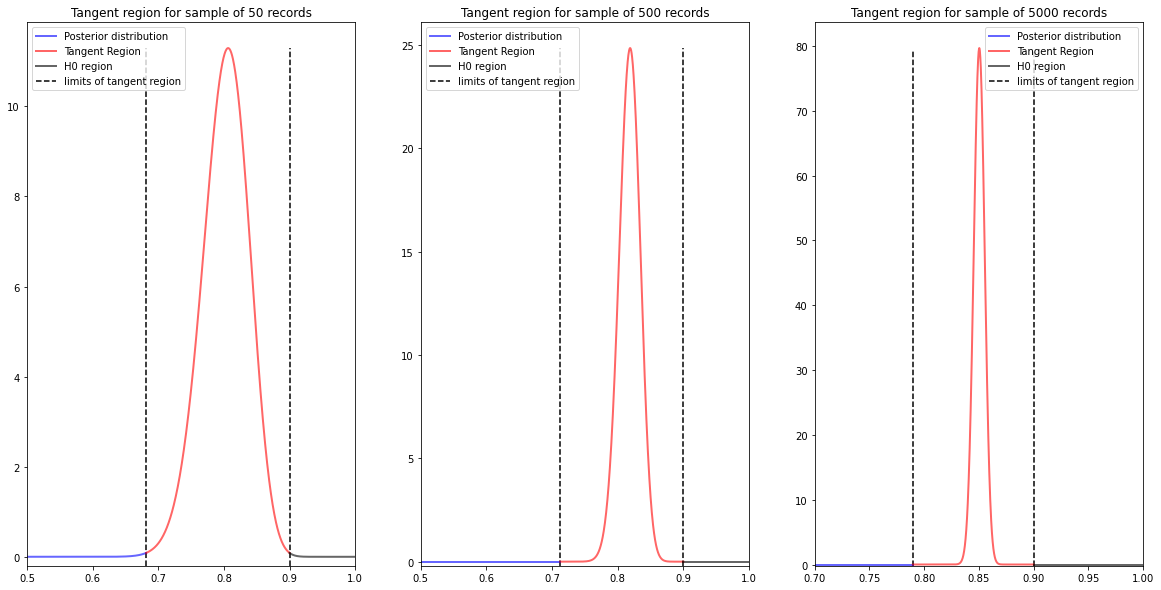

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(20,10))

for i, key in enumerate(results):
    x1 = np.linspace(0, results[key]['tg_region'][0], 500)
    x2 = np.linspace(results[key]['tg_region'][0], results[key]['tg_region'][1], 500)
    x3 = np.linspace(results[key]['tg_region'][1], 1, 200)
    ax[i].plot(x1, results[key]['posterior'].pdf(x1),
             'b-', lw=2, alpha=0.6, label='Posterior distribution')
    ax[i].plot(x2, results[key]['posterior'].pdf(x2),
         'r-', lw=2, alpha=0.6, label='Tangent Region')
    ax[i].plot(x3, results[key]['posterior'].pdf(x3),
         'black', lw=2, alpha=0.6, label='H0 region')
    ax[i].vlines(
        results[key]['tg_region'], 
        -0.2, 
        max(results[key]['posterior'].pdf(x)), 
        'black',
        linestyles='dashed',
        label='limits of tangent region'
    )
    ax[i].legend()
    ax[i].set_title(f'Tangent region for sample of {key} records')
    ax[i].set_ylim(-0.2)
    if i == 2:
        ax[i].set_xlim(0.7, 1)
    else:
        ax[i].set_xlim(0.5, 1)
plt.show()

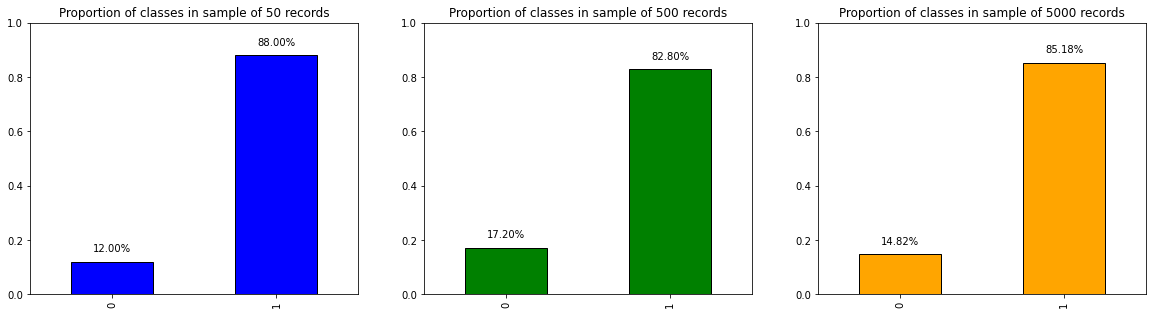

In [94]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
colors = ['blue', 'green', 'orange']
for i, key in enumerate(results):
    results[key]['sample_dist'].plot(kind='bar', color=colors[i], ax=ax[i], ec='black')
    ax[i].set_ylim(0, 1)
    ax[i].set_title(f'Proportion of classes in sample of {key} records')
    for x, y in enumerate(results[key]['sample_dist']):
        label = "{:.2f}%".format(y*100)
        ax[i].annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

In [115]:
def format_results(results):
    results_df = pd.DataFrame.from_dict(results).T
    results_df['a_posterior'] = results_df['posterior'].apply(lambda x: x.args[0])
    results_df['b_posterior'] = results_df['posterior'].apply(lambda x: x.args[1])
    results_df['tg_region'] = results_df['tg_region'].apply(lambda x: (round(x[0], 2), round(x[1], 2)))
    results_df['expected_value'] = (results_df['a_posterior'] / (results_df['a_posterior'] + results_df['b_posterior'])).round(3)
    results_df['e_value'] = results_df['e_value'].apply(lambda x: '{:.2e}'.format(x))
    return results_df[['a_posterior', 'b_posterior', 'expected_value', 'tg_region', 'e_value']]

results_df = format_results(results)
results_df

,a_posterior,b_posterior,expected_value,tg_region,e_value
50,101,25,0.802,"(0.68, 0.9)",1.71e-03
500,471,105,0.818,"(0.71, 0.9)",3.61e-09
5000,4316,760,0.850,"(0.79, 0.9)",1.11e-16
